In [6]:
import pandas as pd

df = pd.read_excel("/Users/yushengyi/Desktop/副本sum.xlsx", engine="openpyxl")
print(df.columns)


Index(['title', 'pub_date', 'content', 'link'], dtype='object')


In [7]:
import pandas as pd
import re
from collections import Counter

# ============ 1. Load Loughran-McDonald Dictionary ============
lm = pd.read_csv("/Users/yushengyi/Desktop/Loughran-McDonald_MasterDictionary_1993-2024.csv")

positive_words = set(lm[lm['Positive'] > 0]['Word'].str.lower())
negative_words = set(lm[lm['Negative'] > 0]['Word'].str.lower())

print("LM dictionary loaded:",
      len(positive_words), "positive words,",
      len(negative_words), "negative words")


# ============ 2. Load your news data correctly ============
df = pd.read_excel("/Users/yushengyi/Desktop/副本sum.xlsx", engine="openpyxl")


# ============ 3. Use correct column names ============
df['date'] = pd.to_datetime(df['pub_date']).dt.date
df['text'] = df['content']


# ============ 4. Clean text ============
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', ' ', text)
    return text.split()


# ============ 5. Compute sentiment for each article ============
def compute_sentiment(text):
    tokens = clean_text(text)
    counter = Counter(tokens)

    pos = sum(counter[w] for w in positive_words if w in counter)
    neg = sum(counter[w] for w in negative_words if w in counter)

    if pos + neg == 0:
        return 0
    return (pos - neg) / (pos + neg)


df['sentiment'] = df['text'].apply(compute_sentiment)


# ============ 6. Aggregate daily ============
daily_sent = df.groupby("date")['sentiment'].mean().reset_index()


# ============ 7. Compute sentiment change ============
daily_sent['sent_change'] = daily_sent['sentiment'].diff()


# ============ 8. Save new CSV to Desktop ============
daily_sent.to_csv("/Users/yushengyi/Desktop/daily_sentiment.csv",
                  index=False)

print("Saved to: Desktop/daily_sentiment.csv")
print(daily_sent.head())


LM dictionary loaded: 347 positive words, 2345 negative words
Saved to: Desktop/daily_sentiment.csv
         date  sentiment  sent_change
0  2022-07-28  -0.294118          NaN
1  2022-09-08  -0.250000     0.044118
2  2022-10-21  -0.500000    -0.250000
3  2022-12-01  -0.466667     0.033333
4  2022-12-06   0.176471     0.643137


In [8]:
daily_sent.head()


,date,sentiment,sent_change
0,2022-07-28,-0.294118,NaN
1,2022-09-08,-0.250000,0.044118
2,2022-10-21,-0.500000,-0.250000
3,2022-12-01,-0.466667,0.033333
4,2022-12-06,0.176471,0.643137


In [10]:
import yfinance as yf
tickers = ['^GSPC', '^DJI', '^IXIC', 'GC=F', 'CL=F']

raw = yf.download(tickers, start="2015-01-01")

data = raw['Close']   # <=== 关键修正
data.head()


/var/folders/mv/jbhbnm41145_29g754x7815h0000gn/T/ipykernel_15372/544021273.py:4: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start="2015-01-01")
[*********************100%***********************]  5 of 5 completed


Ticker,CL=F,GC=F,^DJI,^GSPC,^IXIC
Date,,,,,
2015-01-02,52.689999,1186.000000,17832.990234,2058.199951,4726.810059
2015-01-05,50.040001,1203.900024,17501.650391,2020.579956,4652.569824
2015-01-06,47.930000,1219.300049,17371.640625,2002.609985,4592.740234
2015-01-07,48.650002,1210.599976,17584.519531,2025.900024,4650.470215
2015-01-08,48.790001,1208.400024,17907.869141,2062.139893,4736.189941


/var/folders/mv/jbhbnm41145_29g754x7815h0000gn/T/ipykernel_15372/1928372322.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start="2022-01-01")
[*********************100%***********************]  5 of 5 completed
/var/folders/mv/jbhbnm41145_29g754x7815h0000gn/T/ipykernel_15372/1928372322.py:27: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[col + '_ret'] = df[col].pct_change()
/var/folders/mv/jbhbnm41145_29g754x7815h0000gn/T/ipykernel_15372/1928372322.py:27: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df[col + '_ret'] = df[col

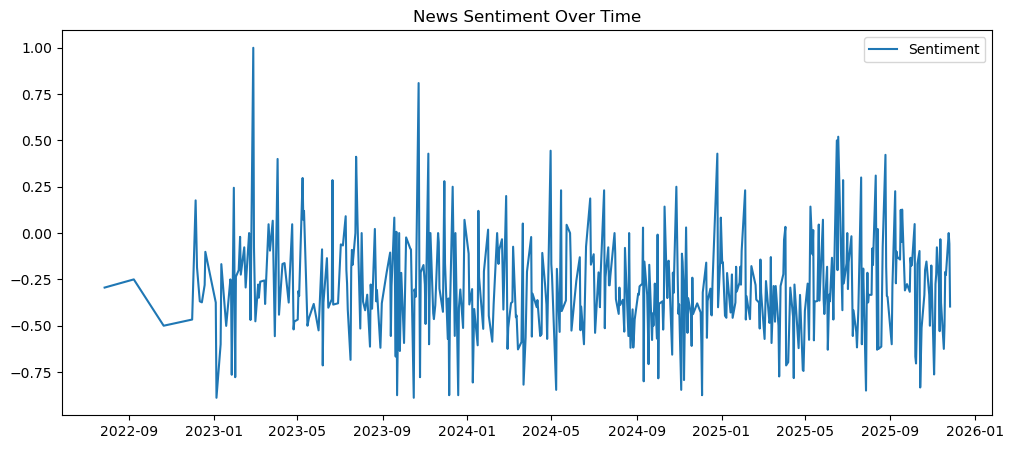

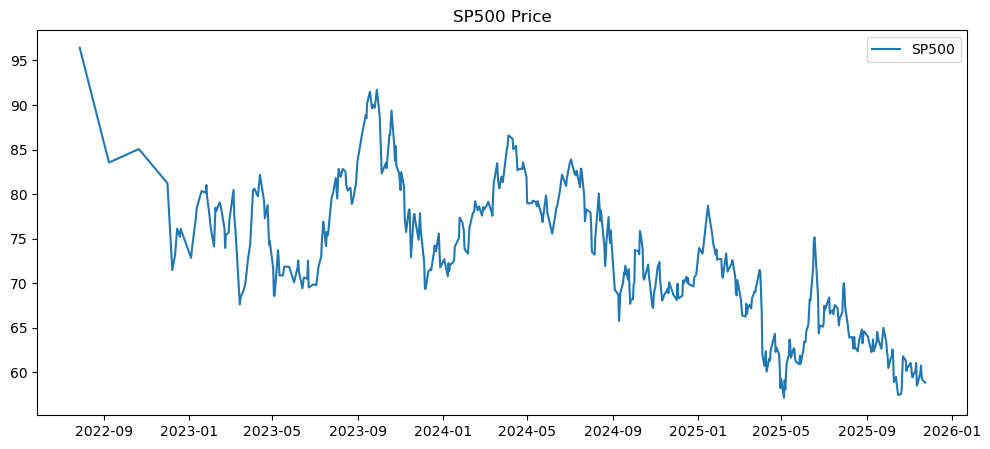

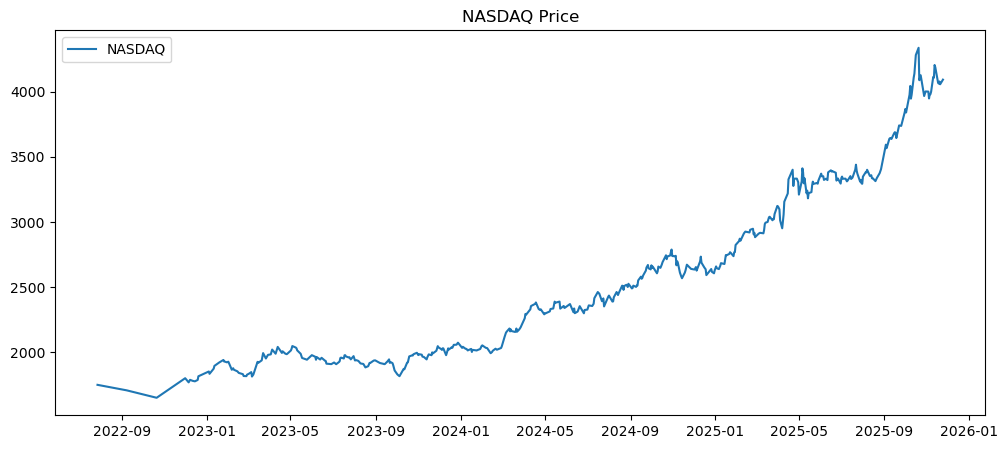

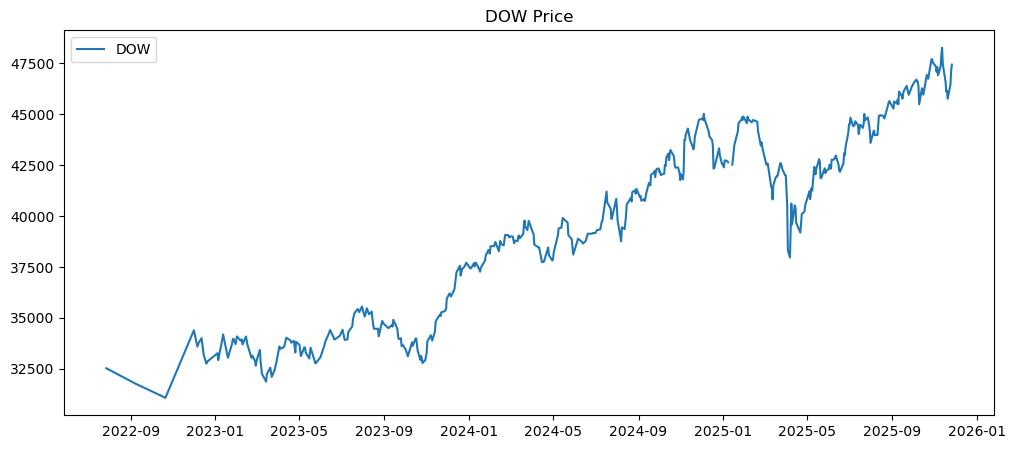

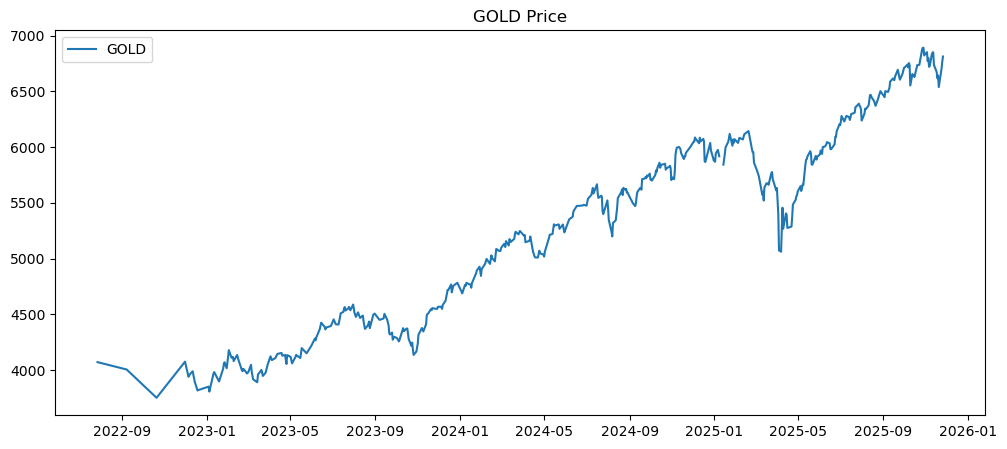

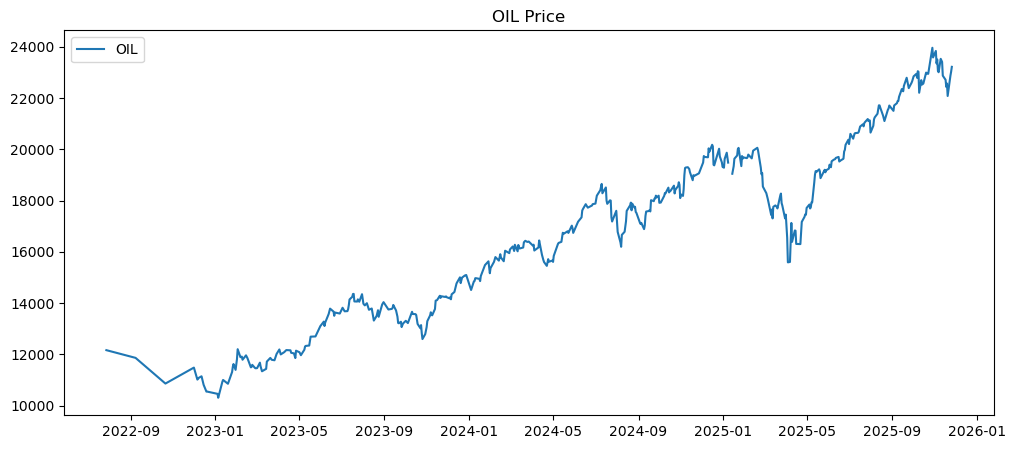

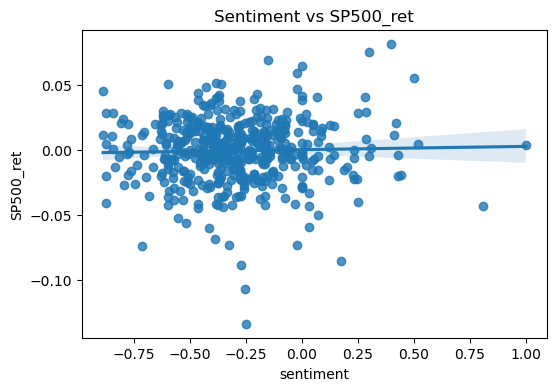

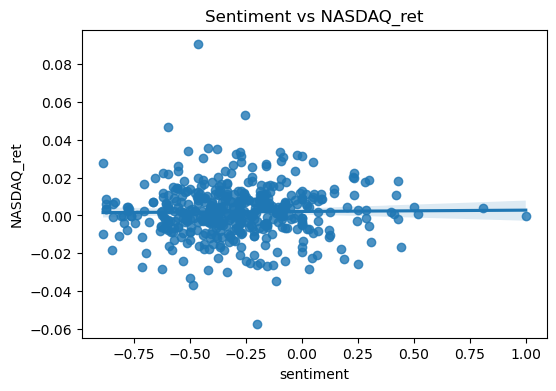

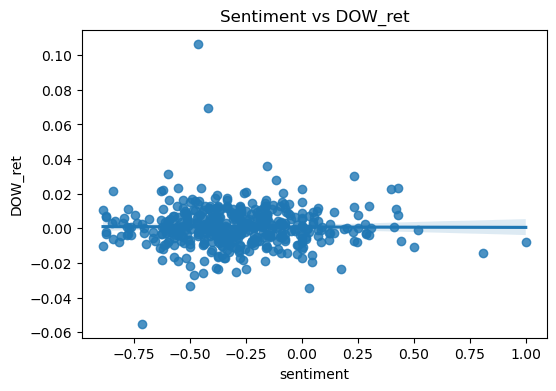

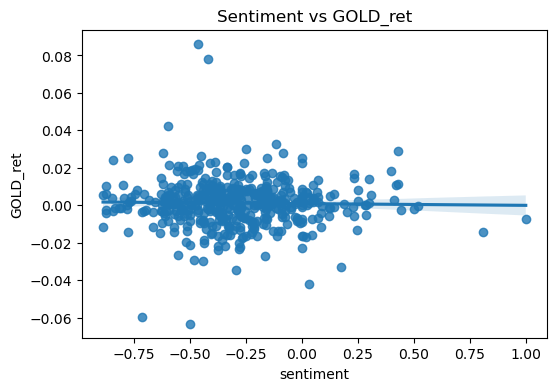

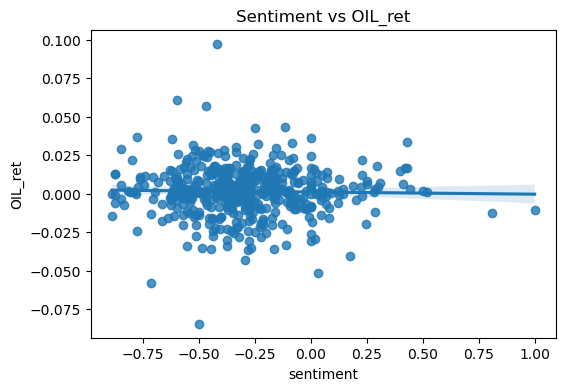

Correlation matrix:
             sentiment  SP500_ret  NASDAQ_ret   DOW_ret  GOLD_ret   OIL_ret
sentiment    1.000000   0.027760    0.013757 -0.005439 -0.019975 -0.023127
SP500_ret    0.027760   1.000000    0.068757  0.105693  0.140780  0.128893
NASDAQ_ret   0.013757   0.068757    1.000000  0.241328  0.246076  0.196069
DOW_ret     -0.005439   0.105693    0.241328  1.000000  0.898074  0.756477
GOLD_ret    -0.019975   0.140780    0.246076  0.898074  1.000000  0.952463
OIL_ret     -0.023127   0.128893    0.196069  0.756477  0.952463  1.000000
                            OLS Regression Results                            
Dep. Variable:              SP500_ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.1864
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.830
Time:                        19:34:38   Log-Likelihood:    

In [13]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# 1. Load sentiment CSV
sent = pd.read_csv("/Users/yushengyi/Desktop/daily_sentiment.csv")
sent['date'] = pd.to_datetime(sent['date'])
sent.set_index('date', inplace=True)

# 2. Download five market indicators
tickers = ['^GSPC','^IXIC','^DJI','GC=F','CL=F']
raw = yf.download(tickers, start="2022-01-01")

# <-- FIX for Adj Close missing -->
if 'Adj Close' in raw.columns.levels[0]:
    data = raw['Adj Close']
else:
    data = raw['Close']

data.columns = ['SP500','NASDAQ','DOW','GOLD','OIL']

# 3. Merge sentiment + market data
df = data.merge(sent, left_index=True, right_index=True, how='inner')

# 4. Compute returns
for col in ['SP500','NASDAQ','DOW','GOLD','OIL']:
    df[col + '_ret'] = df[col].pct_change()

# 5. Plot sentiment
plt.figure(figsize=(12,5))
plt.plot(df.index, df['sentiment'], label='Sentiment')
plt.title("News Sentiment Over Time")
plt.legend()
plt.show()

# 6. Plot prices
for col in ['SP500','NASDAQ','DOW','GOLD','OIL']:
    plt.figure(figsize=(12,5))
    plt.plot(df.index, df[col], label=col)
    plt.title(col + " Price")
    plt.legend()
    plt.show()

# 7. Scatter plots
import seaborn as sns

for col in ['SP500_ret','NASDAQ_ret','DOW_ret','GOLD_ret','OIL_ret']:
    plt.figure(figsize=(6,4))
    sns.regplot(x=df['sentiment'], y=df[col])
    plt.title("Sentiment vs " + col)
    plt.show()

# 8. Correlation matrix
corr = df[['sentiment','SP500_ret','NASDAQ_ret','DOW_ret','GOLD_ret','OIL_ret']].corr()
print("Correlation matrix:\n", corr)

# 9. Simple OLS regression
import statsmodels.api as sm

X = sm.add_constant(df[['sentiment','sent_change']])
y = df['SP500_ret']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


In [14]:
df['SP500_ret_lag1'] = df['SP500_ret'].shift(-1)
df = df[df.index.dayofweek < 5]

X = sm.add_constant(df[['sent_change','sentiment']])
y = df['SP500_ret_lag1']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:         SP500_ret_lag1   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.1295
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.879
Time:                        19:40:55   Log-Likelihood:                 1079.0
No. Observations:                 469   AIC:                            -2152.
Df Residuals:                     466   BIC:                            -2140.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0009      0.002     -0.457      

In [15]:
df['SP500_ret_lag1'] = df['SP500_ret'].shift(-1)
df['vol'] = df['SP500_ret'].abs()
df['extreme'] = (abs(df['sentiment']) > 0.5).astype(int)

df = df[df.index.dayofweek < 5]

X = sm.add_constant(df[['sent_change','extreme']])
y = df['vol']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.3950
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.674
Time:                        19:47:23   Log-Likelihood:                 1258.6
No. Observations:                 470   AIC:                            -2511.
Df Residuals:                     467   BIC:                            -2499.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0186      0.001     20.642      

In [16]:
weekly = df.resample('W').agg({
    'sentiment':'mean',
    'sent_change':'mean',
    'SP500_ret':'sum'
})


In [17]:
import statsmodels.api as sm

X = sm.add_constant(weekly[['sentiment','sent_change']])
y = weekly['SP500_ret']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              SP500_ret   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.1655
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.848
Time:                        19:48:34   Log-Likelihood:                 271.36
No. Observations:                 158   AIC:                            -536.7
Df Residuals:                     155   BIC:                            -527.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0013      0.008      0.171      

In [18]:
monthly = df.resample('M').agg({
    'sentiment':'mean',
    'sent_change':'mean',
    'SP500_ret':'sum'
})


In [19]:
X = sm.add_constant(monthly[['sentiment','sent_change']])
y = monthly['SP500_ret']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:              SP500_ret   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.039
Method:                 Least Squares   F-statistic:                    0.3047
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.739
Time:                        19:48:54   Log-Likelihood:                 49.366
No. Observations:                  38   AIC:                            -92.73
Df Residuals:                      35   BIC:                            -87.82
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0203      0.042      0.477      

In [20]:
weekly['SP500_ret_lag'] = weekly['SP500_ret'].shift(-1)
monthly['SP500_ret_lag'] = monthly['SP500_ret'].shift(-1)


In [21]:
# ---- WEEKLY ----
weekly = df.resample('W').agg({
    'sentiment':'mean',
    'sent_change':'mean',
    'SP500_ret':'sum'
})

# create next-week return
weekly['SP500_ret_lag'] = weekly['SP500_ret'].shift(-1)

import statsmodels.api as sm

X = sm.add_constant(weekly[['sentiment','sent_change']])
y = weekly['SP500_ret_lag']

weekly_model = sm.OLS(y, X, missing='drop').fit()
print("\n===== WEEKLY RESULTS =====")
print(weekly_model.summary())



===== WEEKLY RESULTS =====
                            OLS Regression Results                            
Dep. Variable:          SP500_ret_lag   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                 -0.008
Method:                 Least Squares   F-statistic:                    0.4051
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.668
Time:                        19:50:31   Log-Likelihood:                 274.99
No. Observations:                 157   AIC:                            -544.0
Df Residuals:                     154   BIC:                            -534.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0034

In [22]:
# ---- MONTHLY ----
monthly = df.resample('M').agg({
    'sentiment':'mean',
    'sent_change':'mean',
    'SP500_ret':'sum'
})

# next-month return
monthly['SP500_ret_lag'] = monthly['SP500_ret'].shift(-1)

X = sm.add_constant(monthly[['sentiment','sent_change']])
y = monthly['SP500_ret_lag']

monthly_model = sm.OLS(y, X, missing='drop').fit()
print("\n===== MONTHLY RESULTS =====")
print(monthly_model.summary())



===== MONTHLY RESULTS =====
                            OLS Regression Results                            
Dep. Variable:          SP500_ret_lag   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                 -0.037
Method:                 Least Squares   F-statistic:                    0.3575
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.702
Time:                        19:50:41   Log-Likelihood:                 50.731
No. Observations:                  37   AIC:                            -95.46
Df Residuals:                      34   BIC:                            -90.63
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.015

In [23]:
weekly['vol'] = weekly['SP500_ret'].abs()
monthly['vol'] = monthly['SP500_ret'].abs()


In [24]:
X = sm.add_constant(weekly[['sentiment','sent_change']])
y = weekly['vol']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     2.603
Date:                Sun, 30 Nov 2025   Prob (F-statistic):             0.0773
Time:                        19:52:02   Log-Likelihood:                 342.16
No. Observations:                 158   AIC:                            -678.3
Df Residuals:                     155   BIC:                            -669.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0418      0.005      8.578      

In [25]:
X = sm.add_constant(monthly[['sentiment','sent_change']])
y = monthly['vol']

model = sm.OLS(y, X, missing='drop').fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    vol   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9225
Date:                Sun, 30 Nov 2025   Prob (F-statistic):              0.407
Time:                        19:52:14   Log-Likelihood:                 66.891
No. Observations:                  38   AIC:                            -127.8
Df Residuals:                      35   BIC:                            -122.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0459      0.027      1.715      